In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

In [25]:
# per-sensor PCA itu sering lebih stabil dan hemat memori. Alurnya:

    #Pisahkan tiap sensor (A2, S11, U2).

    #Untuk setiap sensor:

        #Flatten semua nilai per Model Index.

        #Lakukan normalisasi (agar skala sensor seimbang).

        #Terapkan PCA → ambil 2 dimensi utama.

    #Gabungkan hasil 2 dimensi dari setiap sensor → total 6 fitur per Model Index.

    #Tambahkan kolom damage_type dan severity_level.

In [138]:
# -----------------------------
# Load data
# -----------------------------
df_a2 = pd.read_csv("newData/Result/A2_history_output_single_damage_ 55%.csv")
df_s11 = pd.read_csv("newData/Result/S11_history_output_single_damage_ 55%.csv")
df_u2 = pd.read_csv("newData/Result/U2_history_output_single_damage_ 55%.csv")

In [139]:
# -----------------------------
# Flatten per Model Index
# -----------------------------
def flatten_per_model(df, value_col):
    grouped = []
    model_indices = []
    for mid, sub in df.groupby("Model Index"):
        model_indices.append(mid)
        grouped.append(sub[value_col].values.flatten())
    return model_indices, grouped

mid_a2, flat_a2 = flatten_per_model(df_a2, "A2")
mid_u2, flat_u2 = flatten_per_model(df_u2, "U2")
mid_s11, flat_s11 = flatten_per_model(df_s11, "S11")

In [140]:
# Pastikan model index konsisten
assert mid_a2 == mid_u2 == mid_s11
model_indices = mid_a2


In [141]:
# Fungsi PCA per sensor
def sensor_pca(flat_data, n_comp=2):
    max_len = max(len(v) for v in flat_data)
    def pad_to(arr, length):
        return np.pad(arr, (0, length - len(arr)), constant_values=np.nan)
    data_pad = [pad_to(v, max_len) for v in flat_data]
    X = np.nan_to_num(np.vstack(data_pad))
    Xs = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_comp)
    return pca.fit_transform(Xs)

In [142]:
# -----------------------------
# Apply PCA per sensor
# -----------------------------
A2_pca = sensor_pca(flat_a2, 2)
U2_pca = sensor_pca(flat_u2, 2)
S11_pca = sensor_pca(flat_s11, 2)

# Gabungkan hasil
X_concat = np.hstack([A2_pca, U2_pca, S11_pca])


In [143]:
# -----------------------------
# Buat DataFrame hasil akhir
# -----------------------------
df_feat = pd.DataFrame(X_concat, columns=[
    "A2_PC1", "A2_PC2",
    "U2_PC1", "U2_PC2",
    "S11_PC1", "S11_PC2"
])
df_feat.insert(0, "Model Index", model_indices)
df_feat["damage_type"] = 0
df_feat["severity_level"] = 10
df_feat.to_csv("FA2/temp.csv", index=False)
print(df_feat.head())


   Model Index    A2_PC1     A2_PC2     U2_PC1     U2_PC2    S11_PC1  \
0            1  7.994952   6.771147 -29.078273  -6.486400  25.435075   
1            2 -7.994952   6.771147  29.078273  -6.486400 -24.602033   
2            3 -0.262246 -12.059048  -9.745012  13.511451  -8.722485   
3            4  0.262246 -12.059048   9.745012  13.511451   8.016708   
4            5  4.648451  -9.702449  -7.905331  13.147946   8.700536   

     S11_PC2  damage_type  severity_level  
0   4.523689            0              10  
1 -11.017430            0              10  
2   0.539346            0              10  
3   4.119382            0              10  
4 -12.593603            0              10  


In [44]:
##penggabungan##

In [124]:
# Path folder tempat file csv
folder_path = "FA2/PCA"

# Cari semua file csv di folder
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]

# Baca dan gabungkan
df_list = [pd.read_csv(f) for f in all_files]
combined_df = pd.concat(df_list, ignore_index=True)

# Simpan hasil gabungan
combined_df.to_csv("FA/PCA/features_per_sensor_pca.csv", index=False)

print(f"Total file digabung: {len(all_files)}")
print("features_per_sensor_pca.csv")

Total file digabung: 12
features_per_sensor_pca.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
# -----------------------------
# Load dataset PCA
# -----------------------------
df_pca = pd.read_csv("FA2/features_per_sensor_pca2.csv")

In [146]:
df_pca

,Model Index,A2_PC1,A2_PC2,U2_PC1,U2_PC2,S11_PC1,S11_PC2,damage_type,severity_level
0,1,-8.282241,2.501900,-18.926501,7.061998,-37.483312,-51.767406,1,0
1,2,23.271574,-6.437416,16.018616,5.765257,42.861692,27.364187,1,0
2,3,19.481569,-4.991275,16.040022,6.088951,47.614371,-36.380622,1,0
3,4,-18.384155,4.964363,-19.298590,1.958857,-48.120394,56.861380,1,0
4,5,7.774347,-1.723676,0.381435,-31.761304,2.317966,-6.657580,1,0
...,...,...,...,...,...,...,...,...,...
2107,76,-0.264304,-12.675309,4.072615,15.688047,-15.860856,36.687547,0,10
2108,77,0.071719,-11.752835,3.205995,18.082221,203.271924,-41.942770,0,10
2109,78,-0.071719,-11.752835,-3.205995,18.082221,-193.009299,25.524126,0,10
2110,79,0.015639,-12.127205,2.319392,18.061083,-200.709823,42.948184,0,10


In [147]:
# -----------------------------
# Siapkan Input & Output
# -----------------------------
X = df_pca.drop(columns=["Model Index", "severity_level"], errors="ignore").values  # damage_type tetap masuk input
y = df_pca["severity_level"].values

In [148]:
y

array([ 0,  0,  0, ..., 10, 10, 10], dtype=int64)

In [150]:
# Normalisasi input
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [160]:
# Encode target
num_classes = len(np.unique(y))
y_cat = to_categorical(y-1, num_classes=num_classes)  # asumsi severity mulai dari 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(Xs, y_cat, test_size=0.2, random_state=42)

In [222]:
y_cat

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [161]:
# -----------------------------
# Bangun Neural Network
# -----------------------------
model = models.Sequential([
    layers.Dense(32, activation="relu", input_shape=(Xs.shape[1],)),
    layers.Dense(16, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [162]:
# -----------------------------
# Training
# -----------------------------
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=1000,
                    batch_size=8,
                    verbose=1)


Epoch 1/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1009 - loss: 2.4369 - val_accuracy: 0.1420 - val_loss: 2.3910
Epoch 2/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1341 - loss: 2.3784 - val_accuracy: 0.1124 - val_loss: 2.3732
Epoch 3/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1401 - loss: 2.3581 - val_accuracy: 0.1183 - val_loss: 2.3514
Epoch 4/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1612 - loss: 2.3187 - val_accuracy: 0.1361 - val_loss: 2.3223
Epoch 5/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1649 - loss: 2.2898 - val_accuracy: 0.1361 - val_loss: 2.2945
Epoch 6/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1778 - loss: 2.2456 - val_accuracy: 0.1538 - val_loss: 2.2584
Epoch 7/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2014 - loss: 2.1915 - val_accuracy: 0.1538 - val_loss: 2.2273
Epoch 8/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2228 - loss: 2.1506 - 

In [163]:
# Evaluasi
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (PCA features + damage_type): {acc:.3f}")

Test Accuracy (PCA features + damage_type): 0.541


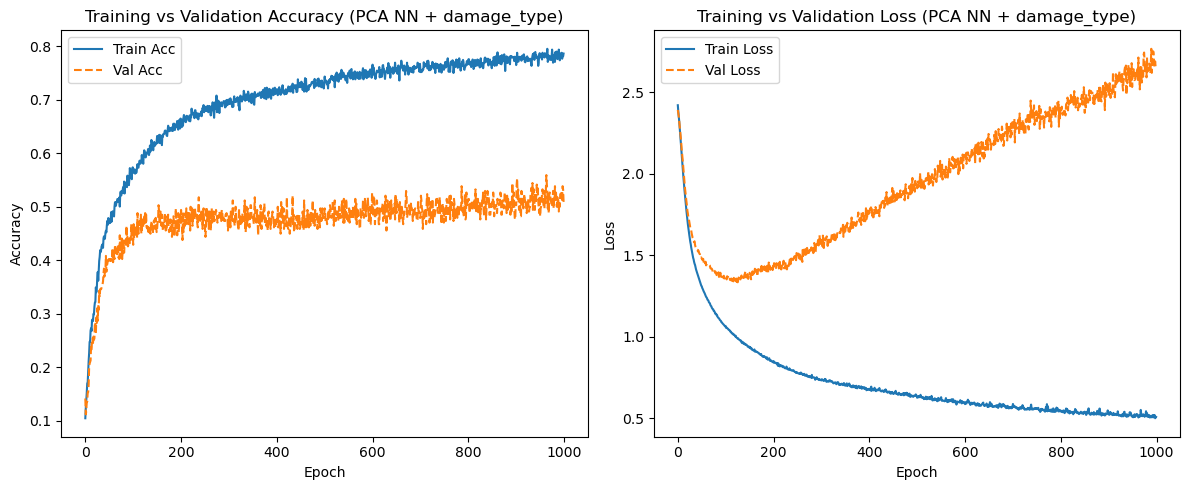

In [164]:
# -----------------------------
# Plot Training Curve
# -----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc", linestyle="--")
plt.title("Training vs Validation Accuracy (PCA NN + damage_type)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss", linestyle="--")
plt.title("Training vs Validation Loss (PCA NN + damage_type)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("nn_pca_damage_type.png", dpi=300)
plt.show()

In [165]:
#✅ Tidak mudah overfitting

#✅ Memakai early stopping

#✅ Ada dropout + L2 regularization

#✅ Label smoothing aktif

#✅ Learning rate disesuaikan agar training lebih stabil

In [167]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [190]:
# -----------------------------
# Siapkan Input & Output
# -----------------------------
X = df_pca.drop(columns=["Model Index", "severity_level"], errors="ignore").values
y = df_pca["severity_level"].values

In [191]:
# Encode target
num_classes = len(np.unique(y))
y_cat = to_categorical(y - 1, num_classes=num_classes)  # asumsi severity mulai dari 1


In [203]:
# Split data (gunakan X bukan Xs kalau belum ada definisi Xs)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)


In [204]:
# -----------------------------
# Normalisasi (sangat penting untuk stabilitas training)
# -----------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [212]:
# -----------------------------
# Bangun Neural Network (dengan regularisasi)
# -----------------------------

model = models.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],),
                 kernel_regularizer=regularizers.l2(1e-5)),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])


In [213]:
# -----------------------------
# Kompilasi model
# -----------------------------
model.compile(
    optimizer=Adam(learning_rate=5e-4),  # naik sedikit dari 1e-4
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),  # smoothing lebih kecil
    metrics=["accuracy"]
)

In [214]:
# -----------------------------
# Callback: Early Stopping
# -----------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# -----------------------------
# Training
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10000,
    batch_size=32,          # batch lebih besar agar gradien stabil
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/10000
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0935 - loss: 2.4320 - val_accuracy: 0.0799 - val_loss: 2.4172
Epoch 2/10000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1107 - loss: 2.4077 - val_accuracy: 0.0799 - val_loss: 2.4048
Epoch 3/10000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1195 - loss: 2.3864 - val_accuracy: 0.0976 - val_loss: 2.3930
Epoch 4/10000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1486 - loss: 2.3617 - val_accuracy: 0.1065 - val_loss: 2.3824
Epoch 5/10000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1274 - loss: 2.3549 - val_accuracy: 0.1361 - val_loss: 2.3677
Epoch 6/10000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1627 - loss: 2.3335 - val_accuracy: 0.1479 - val_loss: 2.3545
Epoch 7/10000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1722 - loss: 2.3199 - val_accuracy: 0.1538 - val_loss: 2.3364
Epoch 8/10000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1885 - loss: 2.3011 - val_acc

In [216]:
# -----------------------------
# Evaluasi pada Test Data
# -----------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")



✅ Test Accuracy: 0.6738 | Test Loss: 1.1097


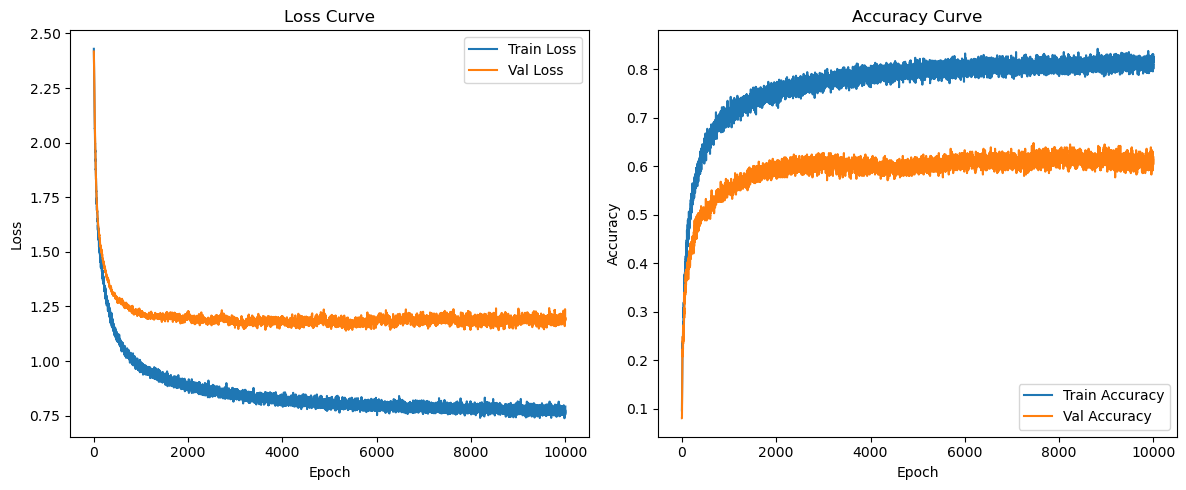

In [217]:
# -----------------------------
# Plot hasil training
# -----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [219]:
# -----------------------------
# Evaluasi Model (Confusion Matrix + ROC Curve)
# -----------------------------
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# ----- Prediksi -----
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


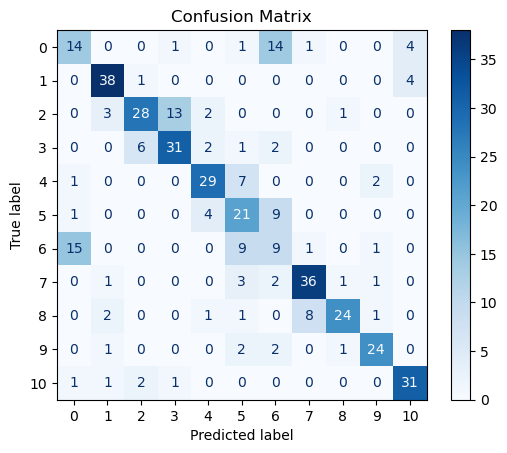


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.4375    0.4000    0.4179        35
           1     0.8261    0.8837    0.8539        43
           2     0.7568    0.5957    0.6667        47
           3     0.6739    0.7381    0.7045        42
           4     0.7632    0.7436    0.7532        39
           5     0.4667    0.6000    0.5250        35
           6     0.2368    0.2571    0.2466        35
           7     0.7826    0.8182    0.8000        44
           8     0.8889    0.6486    0.7500        37
           9     0.8276    0.8000    0.8136        30
          10     0.7949    0.8611    0.8267        36

    accuracy                         0.6738       423
   macro avg     0.6777    0.6678    0.6689       423
weighted avg     0.6852    0.6738    0.6756       423



In [220]:
# ----- Confusion Matrix -----
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ----- Classification Report -----
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

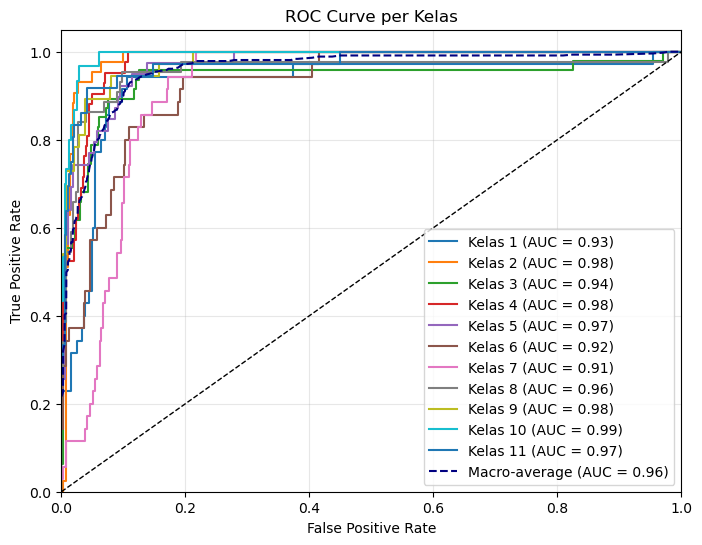

In [221]:

# =========================================================
# 🧠 ROC Curve untuk Multi-Class
# =========================================================

# One-hot encode label jika belum
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))

# ROC per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC per kelas
plt.figure(figsize=(8,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'Kelas {i+1} (AUC = {roc_auc[i]:.2f})')
    
# Macro-average line
plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--',
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
### CROSS VALIDATION#####

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [23]:

# ----------------------------------------
# 1️⃣ Siapkan Input & Target
# ----------------------------------------
X = df_pca.drop(columns=["Model Index", "severity_level"], errors="ignore").values
y = df_pca["severity_level"].values
y = y - y.min()  # pastikan mulai dari 0

num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)


In [24]:
# ----------------------------------------
# 2️⃣ Setup K-Fold
# ----------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
acc_per_fold, loss_per_fold, roc_auc_all = [], [], []
history_all = []
fold_no = 1


🔁 Fold 1 -----------------------------


C:\Users\AkingAyaAyesh\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0973 - loss: 2.4466 - val_accuracy: 0.0118 - val_loss: 2.4916
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1303 - loss: 2.3789 - val_accuracy: 0.0030 - val_loss: 2.6334
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1574 - loss: 2.3392 - val_accuracy: 0.0000e+00 - val_loss: 2.7961
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1326 - loss: 2.3117 - val_accuracy: 0.0000e+00 - val_loss: 2.9611
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1638 - loss: 2.2758 - val_accuracy: 0.0000e+00 - val_loss: 3.1762
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1570 - loss: 2.2529 - val_accuracy: 0.0000e+00 - val_loss: 3.4011
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1569 - loss: 2.2196 - val_accuracy: 0.0000e+00 - val_loss: 3.6035
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1707 - loss: 2.1920 - val

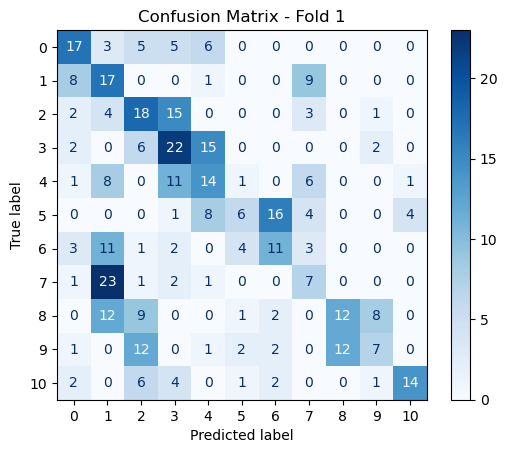

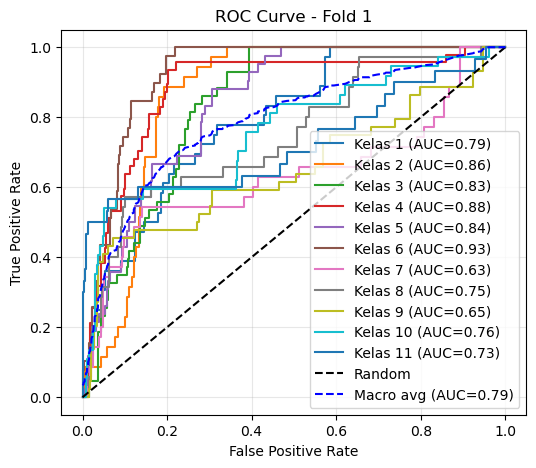


🔁 Fold 2 -----------------------------
Epoch 1/100


C:\Users\AkingAyaAyesh\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1152 - loss: 2.4116 - val_accuracy: 0.0296 - val_loss: 2.7264
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1607 - loss: 2.3365 - val_accuracy: 0.0296 - val_loss: 2.9063
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1649 - loss: 2.3025 - val_accuracy: 0.0000e+00 - val_loss: 3.0828
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1461 - loss: 2.2823 - val_accuracy: 0.0000e+00 - val_loss: 3.2639
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1810 - loss: 2.2245 - val_accuracy: 0.0000e+00 - val_loss: 3.4655
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1596 - loss: 2.2153 - val_accuracy: 0.0000e+00 - val_loss: 3.6234
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1753 - loss: 2.1716 - val_accuracy: 0.0000e+00 - val_loss: 3.8061
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1876 - loss: 2.1429 - val_accuracy: 0

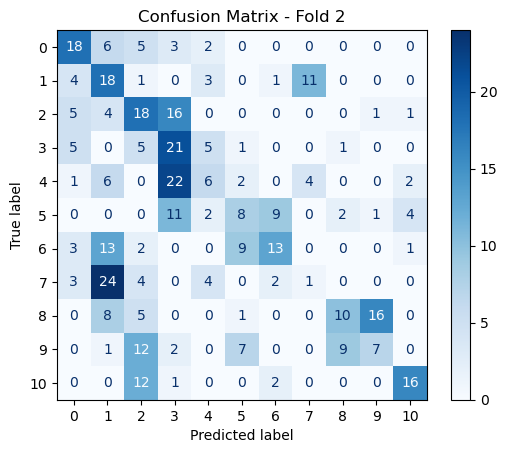

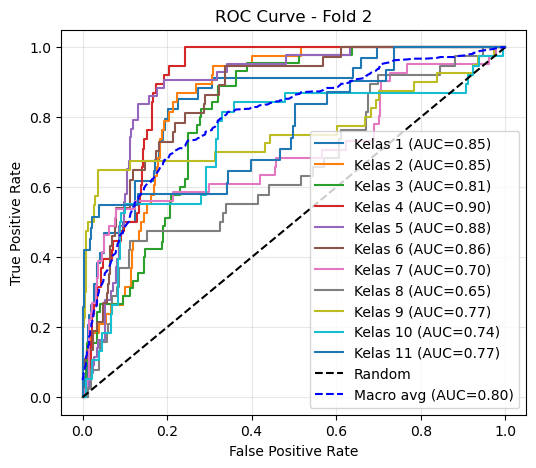


🔁 Fold 3 -----------------------------
Epoch 1/100


C:\Users\AkingAyaAyesh\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0913 - loss: 2.4459 - val_accuracy: 0.0237 - val_loss: 2.4674
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1010 - loss: 2.3797 - val_accuracy: 0.0237 - val_loss: 2.6285
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1265 - loss: 2.3451 - val_accuracy: 0.0207 - val_loss: 2.8092
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1555 - loss: 2.3058 - val_accuracy: 0.0207 - val_loss: 3.0239
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1395 - loss: 2.2712 - val_accuracy: 0.0030 - val_loss: 3.2625
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1781 - loss: 2.2304 - val_accuracy: 0.0000e+00 - val_loss: 3.4904
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1836 - loss: 2.2049 - val_accuracy: 0.0000e+00 - val_loss: 3.7097
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1850 - loss: 2.1907 - val_accuracy: 0.0000e+00 - v

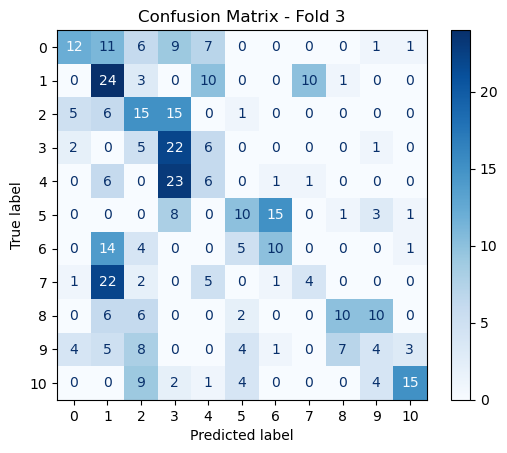

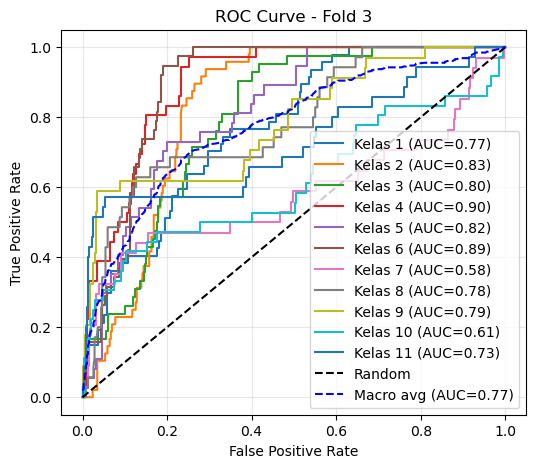


🔁 Fold 4 -----------------------------
Epoch 1/100


C:\Users\AkingAyaAyesh\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1295 - loss: 2.3936 - val_accuracy: 0.0000e+00 - val_loss: 2.5839
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1201 - loss: 2.3545 - val_accuracy: 0.0000e+00 - val_loss: 2.7548
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1287 - loss: 2.3179 - val_accuracy: 0.0000e+00 - val_loss: 2.9735
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1478 - loss: 2.2824 - val_accuracy: 0.0000e+00 - val_loss: 3.1904
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1779 - loss: 2.2502 - val_accuracy: 0.0000e+00 - val_loss: 3.4402
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1696 - loss: 2.2266 - val_accuracy: 0.0000e+00 - val_loss: 3.6633
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1788 - loss: 2.1868 - val_accuracy: 0.0000e+00 - val_loss: 3.8508
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1786 - loss: 2.1551 - val_acc

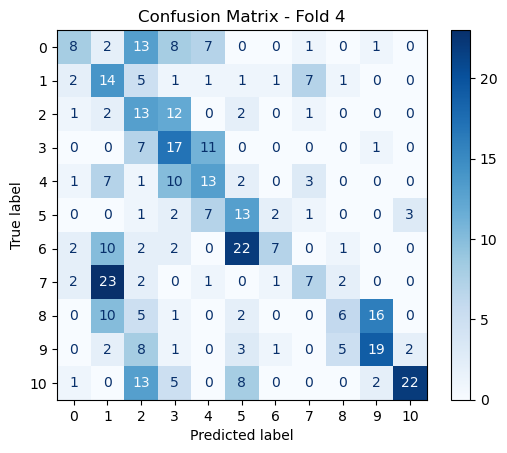

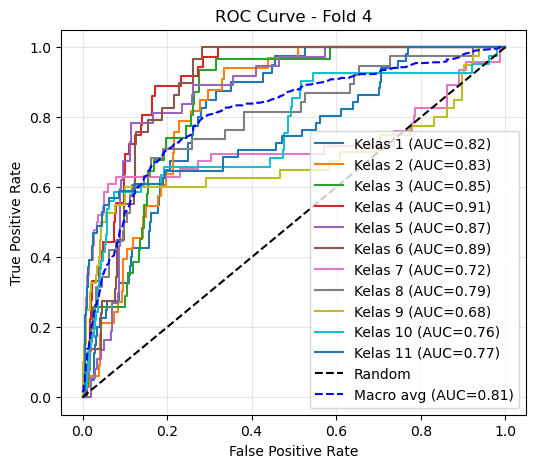


🔁 Fold 5 -----------------------------
Epoch 1/100


C:\Users\AkingAyaAyesh\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0816 - loss: 2.4241 - val_accuracy: 0.0533 - val_loss: 2.4809
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1322 - loss: 2.3740 - val_accuracy: 0.0237 - val_loss: 2.6071
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1557 - loss: 2.3320 - val_accuracy: 0.0000e+00 - val_loss: 2.7535
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1570 - loss: 2.3102 - val_accuracy: 0.0000e+00 - val_loss: 2.9337
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1629 - loss: 2.2835 - val_accuracy: 0.0000e+00 - val_loss: 3.1234
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1561 - loss: 2.2489 - val_accuracy: 0.0000e+00 - val_loss: 3.3543
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1709 - loss: 2.2134 - val_accuracy: 0.0000e+00 - val_loss: 3.5579
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1887 - loss: 2.1805 - val_accuracy: 0

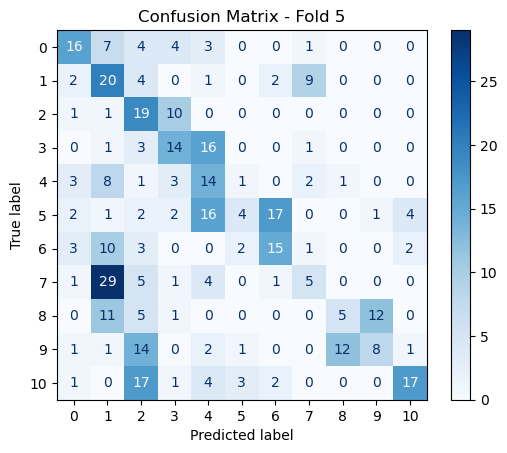

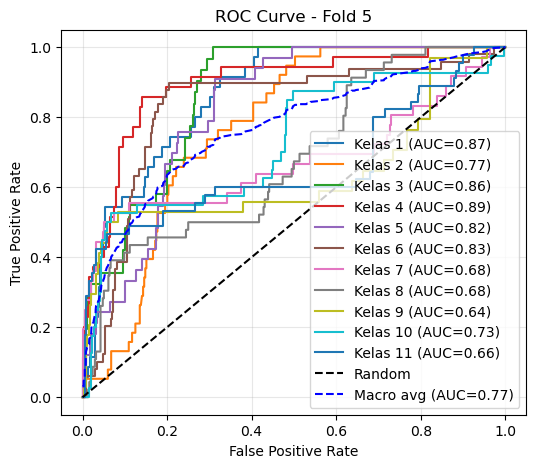

In [25]:
# ----------------------------------------
# 3️⃣ Loop Tiap Fold
# ----------------------------------------
for train_idx, val_idx in kfold.split(X, y_cat):
    print(f"\n🔁 Fold {fold_no} -----------------------------")

    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    # Normalisasi per fold (fit di train saja, transform di val juga)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Bangun model
    model = models.Sequential([
        layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],),
                     kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )

    # Training
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        verbose=1
    )
    history_all.append(history.history)

    # Evaluasi
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"✅ Fold {fold_no} - Loss: {scores[0]:.4f}, Accuracy: {scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # ----------------------------------------
    # Confusion Matrix
    # ----------------------------------------
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - Fold {fold_no}")
    plt.show()

    # ----------------------------------------
    # ROC Curve (multi-class)
    # ----------------------------------------
    y_val_bin = label_binarize(y_true, classes=np.arange(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    roc_auc_macro = auc(all_fpr, mean_tpr)
    roc_auc_all.append(roc_auc_macro)

    plt.figure(figsize=(6,5))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Kelas {i+1} (AUC={roc_auc[i]:.2f})')
    plt.plot([0,1],[0,1],'k--',label='Random')
    plt.plot(all_fpr, mean_tpr, 'b--', label=f'Macro avg (AUC={roc_auc_macro:.2f})')
    plt.title(f"ROC Curve - Fold {fold_no}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    fold_no += 1



In [26]:
# ----------------------------------------
# 4️⃣ Ringkasan Akhir
# ----------------------------------------
print("\n📊 Hasil Cross Validation (5-Fold):")
for i in range(len(acc_per_fold)):
    print(f"Fold {i+1}: Loss={loss_per_fold[i]:.4f}, Acc={acc_per_fold[i]:.2f}%, AUC={roc_auc_all[i]:.3f}")

print("\n✅ Rata-rata Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(acc_per_fold), np.std(acc_per_fold)))
print("✅ Rata-rata ROC AUC: %.3f (+/- %.3f)" % (np.mean(roc_auc_all), np.std(roc_auc_all)))




📊 Hasil Cross Validation (5-Fold):
Fold 1: Loss=2.3381, Acc=34.28%, AUC=0.788
Fold 2: Loss=2.3412, Acc=32.15%, AUC=0.799
Fold 3: Loss=2.3190, Acc=31.28%, AUC=0.773
Fold 4: Loss=2.2621, Acc=32.94%, AUC=0.809
Fold 5: Loss=2.5283, Acc=32.46%, AUC=0.767

✅ Rata-rata Accuracy: 32.62% (+/- 0.99%)
✅ Rata-rata ROC AUC: 0.787 (+/- 0.016)


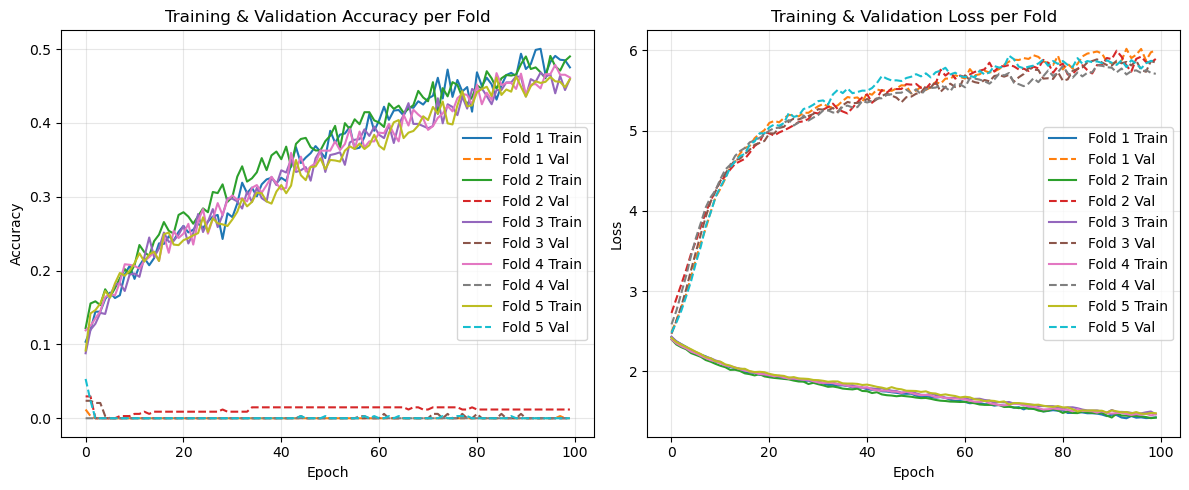

In [27]:
# ----------------------------------------
# 5️⃣ Grafik Akurasi & Loss per Fold
# ----------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for i, h in enumerate(history_all):
    plt.plot(h['accuracy'], label=f'Fold {i+1} Train')
    plt.plot(h['val_accuracy'], '--', label=f'Fold {i+1} Val')
plt.title('Training & Validation Accuracy per Fold')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1,2,2)
for i, h in enumerate(history_all):
    plt.plot(h['loss'], label=f'Fold {i+1} Train')
    plt.plot(h['val_loss'], '--', label=f'Fold {i+1} Val')
plt.title('Training & Validation Loss per Fold')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()